# 2/10/20

Сегодня я понял, что делаю какую-то дичь, поэтому больше ничего переписывать я не буду, буду пользоваться всем, что у меня есть

Мне всё так же нужно переделать сечения

1. Получить список файлов для root кода

In [5]:
from glob import glob

for f in glob('/store17/petrov/data/kskl_sim_custom/tr_ph/*.root')[:3]:
    print(f)

/store17/petrov/data/kskl_sim_custom/tr_ph/tr_ph_kskl_1.05.root
/store17/petrov/data/kskl_sim_custom/tr_ph/tr_ph_kskl_1.075.root
/store17/petrov/data/kskl_sim_custom/tr_ph/tr_ph_kskl_1.125.root


- [x] Сделано
____
Теперь нужно прокрутить новое моделирование через мои root каты

In [18]:
%%bash
source /sl/root/root61600_cc7_64/bin/thisroot.sh
cd /spoolA/petrov/research/code
source KinScript.sh
root -l -b macro.cpp

Setup build environment for ROOT version 6.16.00 in /spoolA/petrov/research/code/KinFitter with BFARCH Linux310_x86_64_gcc485 !

Processing macro.cpp...
(int) 0
Working at file: /store17/petrov/data/kskl_sim_custom/tr_ph/tr_ph_kskl_1.05.root
Out path: ../outputs/model_new_v6/trees/525.00_0.root
Go loop
Is this model? Yes
Washing time: 0.55seconds.
Well done

Working at file: /store17/petrov/data/kskl_sim_custom/tr_ph/tr_ph_kskl_1.075.root
Out path: ../outputs/model_new_v6/trees/537.50_0.root
Go loop
Is this model? Yes
Washing time: 0.43seconds.
Well done

Working at file: /store17/petrov/data/kskl_sim_custom/tr_ph/tr_ph_kskl_1.125.root
Out path: ../outputs/model_new_v6/trees/562.50_0.root
Go loop
Is this model? Yes
Washing time: 0.41seconds.
Well done

Working at file: /store17/petrov/data/kskl_sim_custom/tr_ph/tr_ph_kskl_1.15.root
Out path: ../outputs/model_new_v6/trees/575.00_0.root
Go loop
Is this model? Yes
Washing time: 0.42seconds.
Well done

Working at file: /store17/petrov/data

Info in <TUnixSystem::ACLiC>: creating shared library /spoolA/petrov/research/code/./events_cpp.so


Как всегда всё идёт негладко, а именно файл с количеством мягких фотонов не хочет создаваться

- [x] Решено. Проблема была в том, что в новом моделировании импульсы в ГэВ
_____
Прокручу 11 год и старое моделирование v6

In [19]:
%%bash
source /sl/root/root61600_cc7_64/bin/thisroot.sh
cd /spoolA/petrov/research/code
source KinScript.sh
root -l -b macro.cpp

Process is terminated.


Посмотрю картинку с моделированием

In [98]:
%run code/plot_reg_eff_4.py
%matplotlib inline

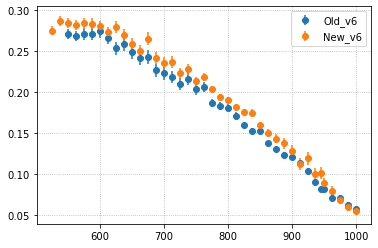

In [99]:
reg_eff("/spoolA/petrov/research/outputs/model_old_v6/trees", 
        "/spoolA/petrov/research/outputs/model_old_v6/soft_ph.csv", "Old_v6", True)
reg_eff("/spoolA/petrov/research/outputs/model_new_v6/trees", 
        "/spoolA/petrov/research/outputs/model_new_v6/soft_ph.csv", "New_v6", True)
plt.legend(frameon=True)
plt.grid(linestyle=':')

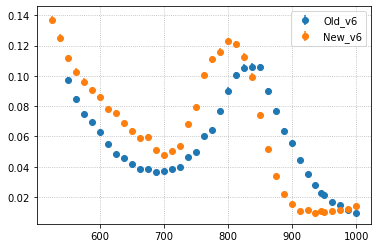

In [100]:
reg_eff("/spoolA/petrov/research/outputs/model_old_v6/trees", 
        "/spoolA/petrov/research/outputs/model_old_v6/soft_ph.csv", "Old_v6", False)
reg_eff("/spoolA/petrov/research/outputs/model_new_v6/trees", 
        "/spoolA/petrov/research/outputs/model_new_v6/soft_ph.csv", "New_v6", False)
plt.legend(frameon=True)
plt.grid(linestyle=':')

Теперь поработаю из `Analysis.ipynb`, получу число событий
- [x] сделано, обновлены файлы с событиями

Теперь можно построить более честные картинки с эффективностями, т.к. теперь числа определяются из фита

In [126]:
df = pd.read_csv('../../outputs/model_old_v6/tables/signal_tablemodel_old_v6.csv', index_col=['name'])
df['Nsig'] /= df.lum
df['dNsig'] /= df.lum
df2 = pd.read_csv('../../outputs/model_new_v6/tables/signal_tablemodel_new_v6.csv', index_col=['name'])
df2['Nsig'] /= df2.lum
df2['dNsig'] /= df2.lum

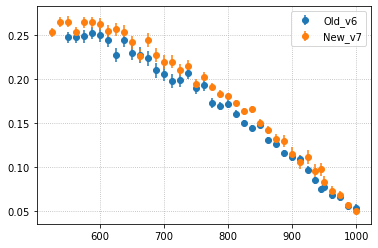

In [128]:
plt.errorbar(data=df, x='Emean', y='Nsig', yerr='dNsig', fmt='o', label='Old_v6')
plt.errorbar(data=df2, x='Emean', y='Nsig', yerr='dNsig', fmt='o', label='New_v6')
plt.grid(linestyle=':')
plt.legend(frameon=True);

Пересчитал сечения 2011 с учётом нового моделирования
<img src="./outputs/images/4NewEffCs.png" alt="drawing" width="600"/>

# 2/11/20
Сегодня я пытаюсь пересчитать рад. поправки и закончить на этом

Для этого беру новые сечения 11 года и завожу `Simultaneous fit.ipynb`

Но сначала обработаю 12 и 17 годы
* [x] Сделано

# 2/12/20
_____
Доделал предыдущую часть, теперь сравнить сечения в двух случаях: с рад.поправкой по всем событиям и рад.поправкой с мягкими фотонами

In [1]:
import pandas as pd
import numpy as np

In [2]:
def born_cs_radcors_comparison(year='11', radcor_folder = '../../outputs/'):
    radcors = [
        pd.read_csv(radcor_folder+'radcors_soft.dat', names=['energy', 'radcor']).sort_values(by='energy'),
        pd.read_csv(radcor_folder+'radcors_all.dat', names=['energy', 'radcor']).sort_values(by='energy'),
    ]
    kskl = [
        pd.read_csv(f'../../outputs/cross_sections/vis_{year}_model_new_v6_soft.csv')\
        [['name', 'Emean', 'dEmin', 'dEmax', 'CS', 'dCS', 'RegEff', 'RegErr']].\
        rename({'Emean': 'energy', 'CS':'cs', 'dCS':'cs_err'}, axis=1),
        pd.read_csv(f'../../outputs/cross_sections/vis_{year}_model_new_v6_all.csv')\
        [['name', 'Emean', 'dEmin', 'dEmax', 'CS', 'dCS', 'RegEff', 'RegErr']].\
        rename({'Emean': 'energy', 'CS':'cs', 'dCS':'cs_err'}, axis=1),
    ]

    kskl[0]['rad'] = np.interp(kskl[0].energy*2e-3, radcors[0].energy, radcors[0].radcor)
    kskl[1]['rad'] = np.interp(kskl[1].energy*2e-3, radcors[1].energy, radcors[1].radcor)
    kskl[0]['cs'] /=  kskl[0].rad
    kskl[0]['cs_err'] /= kskl[0].rad
    kskl[1]['cs'] /=  kskl[1].rad
    kskl[1]['cs_err'] /= kskl[1].rad
    
    kskl[0] = kskl[0].rename({'cs': 'cs_soft', 'cs_err': 'cs_err_soft', 'rad':'rad_soft'}, axis=1)
    return pd.merge( *kskl, on=['name', 'energy', 'dEmin', 'dEmax'])

In [4]:
kskl11 = born_cs_radcors_comparison('11')
kskl12 = born_cs_radcors_comparison('12')
kskl17 = born_cs_radcors_comparison('17')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(13,7)}, font_scale=1.5)
plt.style.use('seaborn-whitegrid')

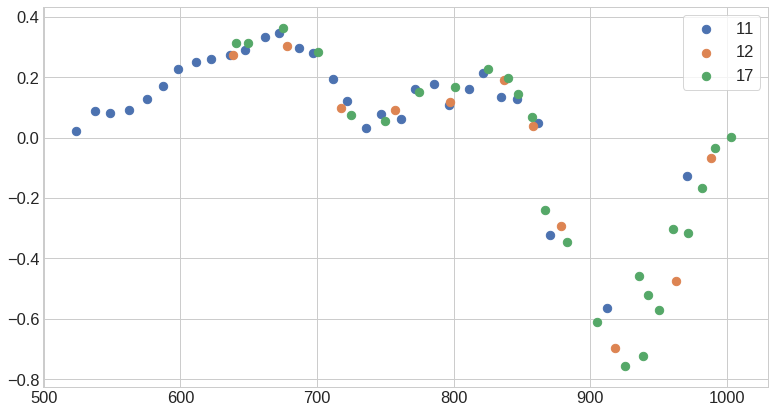

In [46]:
plt.scatter(kskl11.energy, (kskl11['cs_soft'] - kskl11['cs'])/kskl11['cs_soft'], label='11', s=70)
plt.scatter(kskl12.energy, (kskl12['cs_soft'] - kskl12['cs'])/kskl12['cs_soft'], label='12', s=70)
plt.scatter(kskl17.energy, (kskl17['cs_soft'] - kskl17['cs'])/kskl17['cs_soft'], label='17', s=70)
plt.legend(frameon=True);

Наверное это можно считать систематической ошибкой для рад. поправки.
Выглядит страшновато :(

# 2/13/20
_____
Теперь произведение: $\varepsilon_{reg} (1+\delta)$ для мягких фотонов и всех

In [ ]:
k = kskl11
plt.errorbar(x=k.energy, y=k.RegEff_y*k.rad, yerr=k.RegErr_y*k.rad, fmt='o', label='All')
plt.errorbar(x=k.energy, y=k.RegEff_x*k.rad_soft, yerr=k.RegErr_x*k.rad_soft, fmt='o', label='Soft')
plt.legend(frameon=True);
plt.grid(linestyle=':')
plt.xlabel('$\sqrt{s},GeV$')
plt.ylabel('$\\varepsilon_{reg} (1+\delta)$')
plt.title('Эфф.регистрации на радпоправку для сечения, полученного мной');

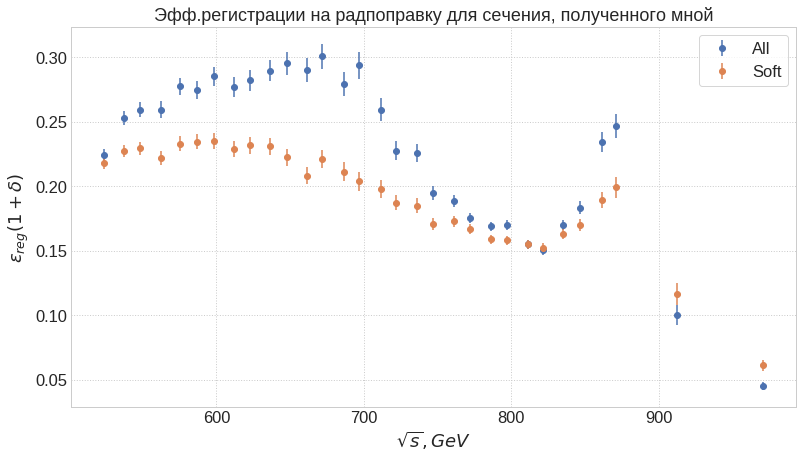

In [7]:
k = kskl11
plt.errorbar(x=k.energy, y=k.RegEff_y*k.rad, yerr=k.RegErr_y*k.rad, fmt='o', label='All')
plt.errorbar(x=k.energy, y=k.RegEff_x*k.rad_soft, yerr=k.RegErr_x*k.rad_soft, fmt='o', label='Soft')
plt.legend(frameon=True);
plt.grid(linestyle=':')
plt.xlabel('$\sqrt{s},GeV$')
plt.ylabel('$\\varepsilon_{reg} (1+\delta)$')
plt.title('Эфф.регистрации на радпоправку для сечения, полученного мной');

Плохие картинки

Теперь можно посчитать радпоправку по сечениям **заложенным в моделирование**, если два варианта сойдутся, то это будет доказательством того, что формула расчёта радпоправок работает верно.

In [55]:
kskl11_check = born_cs_radcors_comparison('11', radcor_folder='outputs/data/')
kskl12_check = born_cs_radcors_comparison('12', radcor_folder='outputs/data/')
kskl17_check = born_cs_radcors_comparison('17', radcor_folder='outputs/data/')

In [56]:
k.head()

,name,energy,dEmin,dEmax,cs_soft,cs_err_soft,RegEff_x,RegErr_x,rad_soft,cs,cs_err,RegEff_y,RegErr_y,rad
0,525.0,523.58,0.0,0.0,14.738054,0.838138,0.24395,0.00500,0.921066,14.839230,0.843895,0.12712,0.00260,1.75549
1,537.5,537.41,0.0,0.0,7.405173,0.299589,0.25769,0.00555,0.886348,6.811638,0.275569,0.11621,0.00250,2.13663
2,550.0,548.44,0.0,0.0,4.615864,0.313172,0.25984,0.00584,0.889606,4.264231,0.289296,0.10652,0.00239,2.34908
3,562.5,562.13,0.0,0.0,3.368461,0.195036,0.24885,0.00610,0.895118,3.124288,0.180887,0.09335,0.00229,2.57265
4,575.0,575.31,0.0,0.0,2.081804,0.198578,0.25997,0.00636,0.900301,1.886937,0.179994,0.09016,0.00220,2.86388


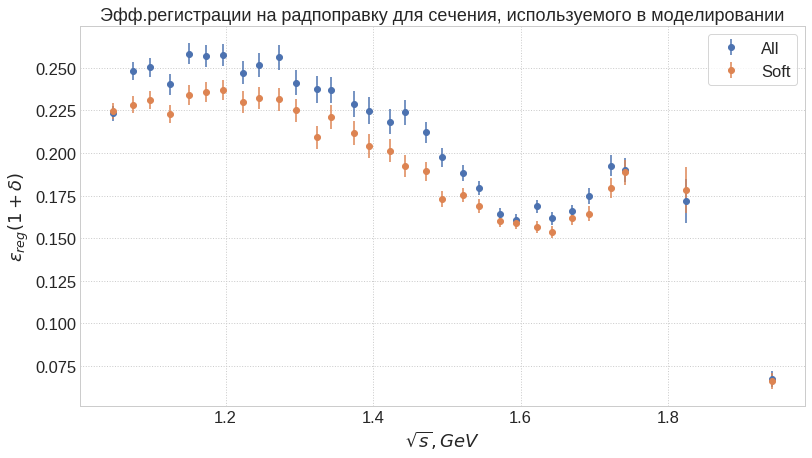

In [57]:
k = kskl11_check
plt.errorbar(x=k.energy*2e-3, y=k.RegEff_y*k.rad, yerr=k.RegErr_y*k.rad, fmt='o', label='All')
plt.errorbar(x=k.energy*2e-3, y=k.RegEff_x*k.rad_soft, yerr=k.RegErr_x*k.rad_soft, fmt='o', label='Soft')
plt.legend(frameon=True);
plt.grid(linestyle=':')
plt.xlabel('$\sqrt{s},GeV$')
plt.ylabel('$\\varepsilon_{reg} (1+\delta)$')
plt.title('Эфф.регистрации на радпоправку для сечения, используемого в моделировании');

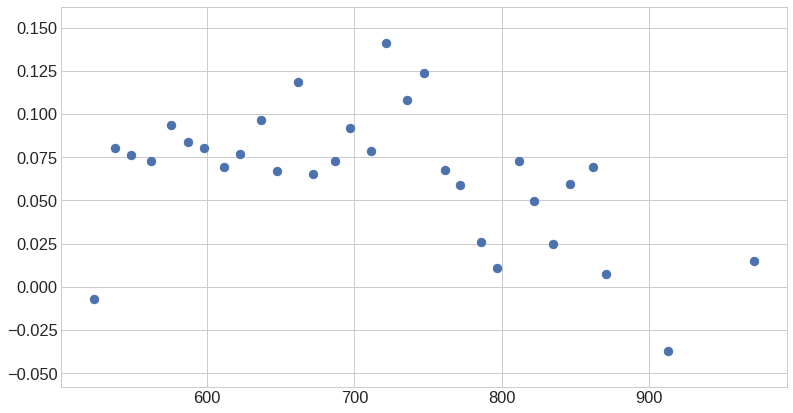

In [58]:
plt.scatter(k.energy, (k['cs_soft'] - k['cs'])/k['cs_soft'], label='11', s=70)